# Lab 3 Assignment
### Authors: Dan Davieau, Paul Panek, Olga Tanyuk, Nathan Wall

### Business Understanding
## Business Understanding  
<font color=blue>Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific
dataset and the stakeholders needs?</font>

Washington, D.C. is the capital of the United States. Washington's population is approaching 700,000 people, and has been growing since 2000 following a half-century of population decline. The city is highly segregated and features a high cost of living. In 2017, the average price of a single family home in the district was $649,000. 

Understanding the various features and similarities between the various neighborhoods provides important insights into the housing market within the district. This analysis will serve as means for a real estate agency to develop profiles of the various wards in DC. By better understanding the housing characteristics of the different wards they can better recommend specific areas to begin there search based on the clients needs.

We will measure effectivenss of different clustering algorithms to seperate various types of homes from the DC data set. For example single family homes on large plots of land should be considered as a different type of home than downtown flat in a 10 story building. The process of evaluating will be based on two criteria.

1) Silhouette Coefficient and other statistical measures to determing the correct amount of clusters to use and our ability to seperate them into distinct categories.

2) Manual evaluation of the observations to identify the similarity betweent he various clusters based on the our own ability to differentiate between different styles of homes.

***

### Data Understanding 1
<font color=blue>Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?</font>

For this data we will be reading in and joining two data sets from Kaggle (https://www.kaggle.com/christophercorrea/dc-residential-properties):

*raw_residential_data.csv* : 
The Computer Assisted Mass Appraisal - Residential data contains attribution on housing characteristics for residential properties, and was created as part of the DC Geographic Information System (DC GIS) for the D.C. Office of the Chief Technology Officer (OCTO) and participating D.C. government agencies.

*raw_address_points.csv* :
The raw address points data contains locations and attributes of Address points as of July 2018. This file is part of the Master Address Repository (MAR) for the D.C. Office of the Chief Technology Officer and DC Department of Consumer and Regulatory Affairs . It contains the standardized addresses in the District of Columbia which are typically placed on the buildings.

The second dataset will only be used as we interpret results to better understands how the various clusters of DC homes relates to the various DC neighborhoods and if any insights can be uncovered.

In [1]:
import pandas as pd
import numpy as np

df1 = pd.read_csv('Data/raw_residential_data.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107154 entries, 0 to 107153
Data columns (total 39 columns):
OBJECTID             107154 non-null int64
SSL                  107154 non-null object
BATHRM               107127 non-null float64
HF_BATHRM            107126 non-null float64
HEAT                 107127 non-null float64
HEAT_D               107127 non-null object
AC                   107127 non-null object
NUM_UNITS            107127 non-null float64
ROOMS                107110 non-null float64
BEDRM                107123 non-null float64
AYB                  107141 non-null float64
YR_RMDL              49446 non-null float64
EYB                  107154 non-null int64
STORIES              107080 non-null float64
SALEDATE             107154 non-null object
PRICE                87866 non-null float64
QUALIFIED            107154 non-null object
SALE_NUM             107154 non-null int64
GBA                  107154 non-null int64
BLDG_NUM             107154 non-null int64
STYLE 

In [2]:
df2 = pd.read_csv('Data/raw_address_points.csv')
df2.info()

C:\Users\otany\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147300 entries, 0 to 147299
Data columns (total 52 columns):
X                             147300 non-null float64
Y                             147300 non-null float64
OBJECTID_12                   147300 non-null int64
SITE_ADDRESS_PK               147300 non-null int64
ADDRESS_ID                    147300 non-null int64
STATUS                        147300 non-null object
SSL                           146935 non-null object
TYPE_                         147300 non-null object
ENTRANCETYPE                  147300 non-null object
ADDRNUM                       145396 non-null float64
ADDRNUMSUFFIX                 2262 non-null object
STNAME                        147300 non-null object
STREET_TYPE                   147300 non-null object
QUADRANT                      147300 non-null object
CITY                          147300 non-null object
STATE                         147300 non-null object
FULLADDRESS                   145396 non-nu

From what we can see we have data on 107,154 different residential. They are measured on 39 different measures where applicable. 

Several of the features are dummy variables of the other and are labeled with "D" we will use the D variables to make one hot endoding simpler to read. A dictionary of those dummy variables can be found in the appendix along with a description of each of the variables.

Below we subset our variables of interest and assess the amount of NULL values and potential outliers that need to get addressed.


In [3]:
#Identify all categorical variables
categories = [['CNDTN_D','CNDTN'],['HEAT_D','HEAT'],['STYLE_D','STYLE'],['STRUCT_D','STRUCT'],['GRADE_D','GRADE'],['ROOF_D','ROOF'],['EXTWALL_D','EXTWALL'],['INTWALL_D','INTWALL']]
cat_drop = []
for c in categories:
    round(df1[c[1]])
    cat_drop.append(c[0])
    
# eliminate redundant dummy variables
df1.drop(cat_drop, inplace=True, axis=1)
df1.head()


,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,...,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM
0,1001,0152 0133,4.0,0.0,7.0,Y,2.0,8.0,4.0,1910.0,...,6.0,4.0,14.0,6.0,6.0,2.0,5.0,24,1680,2018-07-22T18:01:43.000Z
1,1002,0152 0134,3.0,1.0,7.0,Y,2.0,11.0,5.0,1898.0,...,6.0,4.0,14.0,2.0,6.0,2.0,4.0,24,1680,2018-07-22T18:01:43.000Z
2,1003,0152 0135,3.0,1.0,13.0,Y,2.0,9.0,5.0,1910.0,...,6.0,5.0,14.0,2.0,6.0,2.0,4.0,24,1680,2018-07-22T18:01:43.000Z
3,1004,0152 0136,3.0,1.0,13.0,Y,2.0,8.0,5.0,1900.0,...,6.0,4.0,14.0,2.0,6.0,2.0,3.0,24,1680,2018-07-22T18:01:43.000Z
4,1005,0152 0138,2.0,1.0,7.0,Y,1.0,11.0,3.0,1913.0,...,6.0,4.0,14.0,13.0,6.0,1.0,0.0,13,2032,2018-07-22T18:01:43.000Z


In [4]:
print(df1.isnull().sum())

OBJECTID                 0
SSL                      0
BATHRM                  27
HF_BATHRM               28
HEAT                    27
AC                      27
NUM_UNITS               27
ROOMS                   44
BEDRM                   31
AYB                     13
YR_RMDL              57708
EYB                      0
STORIES                 74
SALEDATE                 0
PRICE                19288
QUALIFIED                0
SALE_NUM                 0
GBA                      0
BLDG_NUM                 0
STYLE                   27
STRUCT                  27
GRADE                   27
CNDTN                   27
EXTWALL                 27
ROOF                    27
INTWALL                 27
KITCHENS                28
FIREPLACES              28
USECODE                  0
LANDAREA                 0
GIS_LAST_MOD_DTTM        0
dtype: int64


Our data set is still 107,154 observations but now contains only 31 observations. However, we do see that there are several null values for various features. For each of the categorical or numeric features with 100 or fewer obs we will simply impute the missing values using the most common class or median value. However, the year remodeled, & price stand out and will probably need to be treated differently.

For the year remodeled we will assume that variable is missing when no remodels have been done to the home. Thus, converting the year to bins and treating the 57k with no remodel year as there own class. Clusters with a high proportion of these class homes may provides insights into homes ideal for contractors.

Considering the price is the price of the last sale. Considering the volatility of the housing market over time and inflation that we believe that feature could be misleading, so we will opt to leave it out of our analysis.

In addition to the price category we will also drop several other codes that we have deemed not useful.

In [5]:
bins = [0, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
labels = ['50+','50','40','30','20','10','0']
df1['YR_RMDL_ClASS'] = pd.cut(df1['YR_RMDL'], bins=bins, labels=labels)
df1['YR_RMDL_ClASS'] = df1['YR_RMDL_ClASS'].replace(np.nan, 'NONE', regex=True)

# eliminate unnecessary variables
df1.drop(['PRICE','QUALIFIED','BLDG_NUM','GRADE','CNDTN','EYB','USECODE','GIS_LAST_MOD_DTTM','YR_RMDL','SALEDATE'], inplace=True, axis=1)

In [6]:
df1.head()

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,...,GBA,STYLE,STRUCT,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,LANDAREA,YR_RMDL_ClASS
0,1001,0152 0133,4.0,0.0,7.0,Y,2.0,8.0,4.0,1910.0,...,2522,7.0,7.0,14.0,6.0,6.0,2.0,5.0,1680,30
1,1002,0152 0134,3.0,1.0,7.0,Y,2.0,11.0,5.0,1898.0,...,2567,7.0,7.0,14.0,2.0,6.0,2.0,4.0,1680,10
2,1003,0152 0135,3.0,1.0,13.0,Y,2.0,9.0,5.0,1910.0,...,2522,7.0,7.0,14.0,2.0,6.0,2.0,4.0,1680,10
3,1004,0152 0136,3.0,1.0,13.0,Y,2.0,8.0,5.0,1900.0,...,2484,7.0,7.0,14.0,2.0,6.0,2.0,3.0,1680,10
4,1005,0152 0138,2.0,1.0,7.0,Y,1.0,11.0,3.0,1913.0,...,5255,7.0,8.0,14.0,13.0,6.0,1.0,0.0,2032,0


In [8]:
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

df = DataFrameImputer().fit_transform(df1)

int_col = ['BATHRM','HF_BATHRM','HEAT','NUM_UNITS','ROOMS','BEDRM','AYB','STORIES','STYLE','STRUCT',
           'EXTWALL','ROOF','INTWALL','KITCHENS','FIREPLACES','LANDAREA']

for i in int_col:
    df[i] = df[i].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107154 entries, 0 to 107153
Data columns (total 22 columns):
OBJECTID         107154 non-null int64
SSL              107154 non-null object
BATHRM           107154 non-null int64
HF_BATHRM        107154 non-null int64
HEAT             107154 non-null int64
AC               107154 non-null object
NUM_UNITS        107154 non-null int64
ROOMS            107154 non-null int64
BEDRM            107154 non-null int64
AYB              107154 non-null int64
STORIES          107154 non-null int64
SALE_NUM         107154 non-null int64
GBA              107154 non-null int64
STYLE            107154 non-null int64
STRUCT           107154 non-null int64
EXTWALL          107154 non-null int64
ROOF             107154 non-null int64
INTWALL          107154 non-null int64
KITCHENS         107154 non-null int64
FIREPLACES       107154 non-null int64
LANDAREA         107154 non-null int64
YR_RMDL_ClASS    107154 non-null object
dtypes: int64(19), object(3)

In [9]:
df.head()

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,...,GBA,STYLE,STRUCT,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,LANDAREA,YR_RMDL_ClASS
0,1001,0152 0133,4,0,7,Y,2,8,4,1910,...,2522,7,7,14,6,6,2,5,1680,30
1,1002,0152 0134,3,1,7,Y,2,11,5,1898,...,2567,7,7,14,2,6,2,4,1680,10
2,1003,0152 0135,3,1,13,Y,2,9,5,1910,...,2522,7,7,14,2,6,2,4,1680,10
3,1004,0152 0136,3,1,13,Y,2,8,5,1900,...,2484,7,7,14,2,6,2,3,1680,10
4,1005,0152 0138,2,1,7,Y,1,11,3,1913,...,5255,7,8,14,13,6,1,0,2032,0


We now have a cleaned up set of 22 different features for over 107k homes with all the missing values imputed. Before we begin analysis and clustering of our data we will explore these variables a little further to understand any transformations that may be required or any outliers that need to be addressed.

Additional Outlier Vars that we determined need to be addressed:

*Stories > 200*

These are likely reporting errors as the there is a limit to the height of building in DC that would prevent any building being over 200 stories. This causes us to question any of the validity of the data in these observations, thus we will remove them from our data.

*AYB < 1500*

While it may be possible from some homes to be originally built prior to 1900, these earlier homes represent a very small proportion of our data. The majority of them have years reported as 50 or below. In order to help secure overall data quality we will remove those observations from our data. 

*Style > 25*

Style Dummy variables greater than 25 represent two 'Styles'. Outbuildings & Vacants, neither of which we want to consider in our analysis.

*Kitchens > 20*

As you can see below there is only a single home with > 20 kitchens and considering the other variables this appears to be a 
reprorting error and will be removed from analyis.

*Rooms > 100 or BedRooms > Rooms*

Based on the square footage for the one home with > 100 rooms its seems highly unlikely that that value is accurate. Additionally, any scenario where bedrooms is greater than rooms is impossible so we will not like to use these in our analysis as well.

*GBA > 3200*

90% of the total data set has gross building area <3,200 sq.ft. In order to help secure overall data quality we will remove  observations with higher building area from our data. 

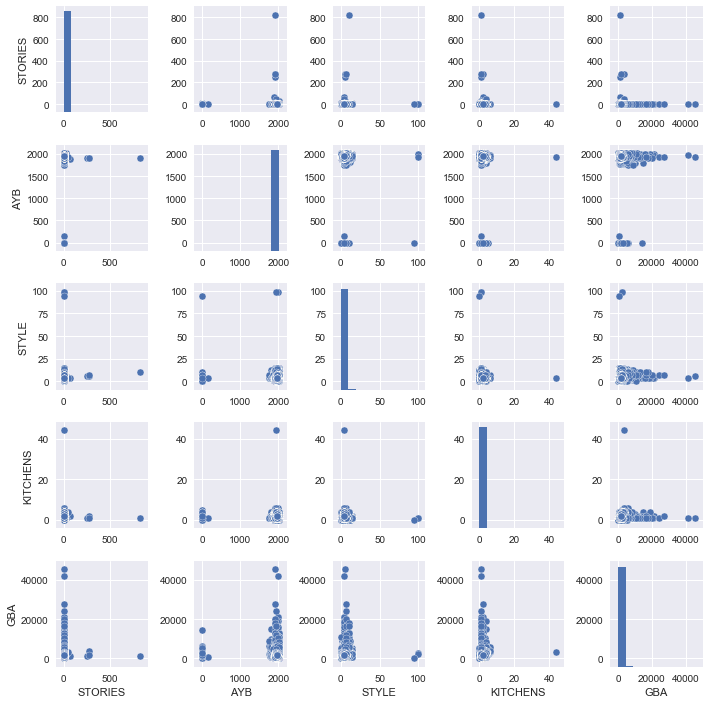

In [10]:
#Plots before outlier Removals
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
plotVar = ['STORIES','AYB','STYLE','KITCHENS','GBA']

sns.pairplot(df[plotVar], size=2)

<bound method _AxesBase.set_yscale of <matplotlib.axes._subplots.AxesSubplot object at 0x0000019822B9B400>>

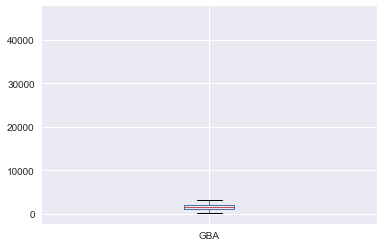

In [11]:
%matplotlib inline
b = df.boxplot(column='GBA')
b.set_yscale

In [12]:
#removal false records
df = df[df.STORIES < 200]
df = df[df.AYB > 1500]
df = df[df.STYLE < 25]
df = df[df.KITCHENS < 20]
df = df[df.ROOMS < 100]
df = df[df.ROOMS >= df.BEDRM]
df = df[df.GBA < 3200]

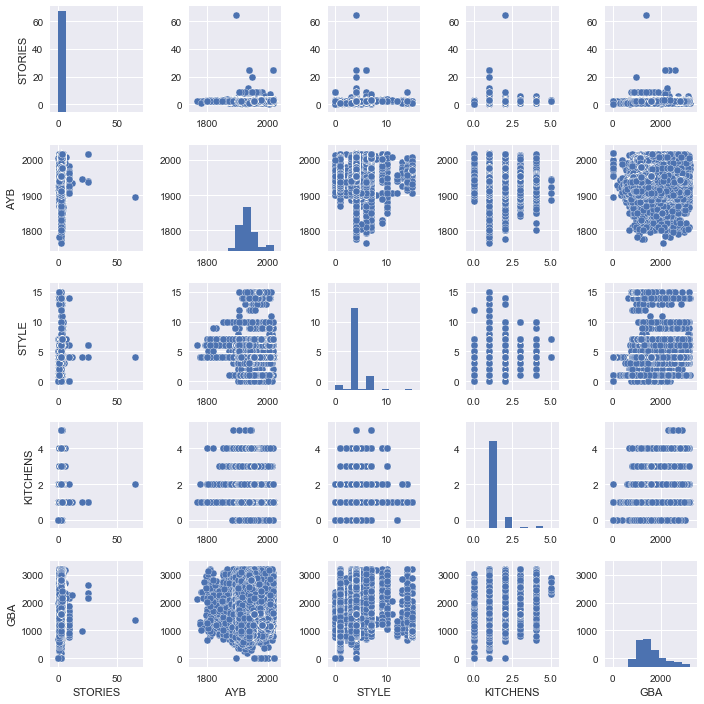

In [13]:
#plots after
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
plotVar = ['STORIES','AYB','STYLE','KITCHENS','GBA']

sns.pairplot(df[plotVar], size=2)

<bound method _AxesBase.set_yscale of <matplotlib.axes._subplots.AxesSubplot object at 0x000001982A875908>>

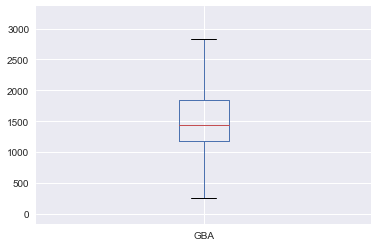

In [14]:
b = df.boxplot(column='GBA')
b.set_yscale

In order to help the client understand the how the home types for the various neighborhoods or wards relate we have to join with data collected through a different source to get distinct location information related to these addresses. However, not all address information is available for all the homes in our set so for the purposes of this we will only consider homes which we have neighborhood information available.

In [15]:
# subset the variables of interest that we care about
df2 = df2.drop_duplicates(['SSL'], keep='last').set_index("SSL")[["LATITUDE","LONGITUDE","ASSESSMENT_NBHD","WARD"]]
# inner join the two datasets 
df = pd.merge(df,df2,how="inner",on="SSL")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100096 entries, 0 to 100095
Data columns (total 26 columns):
OBJECTID           100096 non-null int64
SSL                100096 non-null object
BATHRM             100096 non-null int64
HF_BATHRM          100096 non-null int64
HEAT               100096 non-null int64
AC                 100096 non-null object
NUM_UNITS          100096 non-null int64
ROOMS              100096 non-null int64
BEDRM              100096 non-null int64
AYB                100096 non-null int64
STORIES            100096 non-null int64
SALE_NUM           100096 non-null int64
GBA                100096 non-null int64
STYLE              100096 non-null int64
STRUCT             100096 non-null int64
EXTWALL            100096 non-null int64
ROOF               100096 non-null int64
INTWALL            100096 non-null int64
KITCHENS           100096 non-null int64
FIREPLACES         100096 non-null int64
LANDAREA           100096 non-null int64
YR_RMDL_ClASS      100096 

### Data Understanding 2
<font color=blue>Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.</font>

Let explore our data a little further to better understand the features that may be of importance for our analysis. First we will try to understand some of the different Wards in our data.

(Text(0.5,0,'Latitude'), Text(0,0.5,'Longitude'))

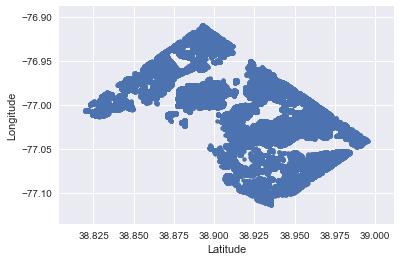

In [16]:
plt.figure()
plt.scatter(df.LATITUDE, df.LONGITUDE, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Latitude'), plt.ylabel('Longitude')

Lets review how many different WARDS we have in the data set and their destribution on the histogram.

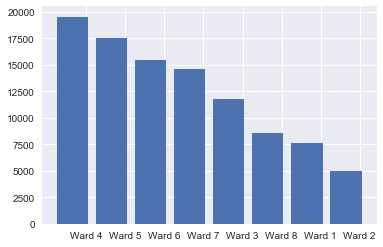

In [17]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

counts = Counter(df.WARD)

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels)
plt.show()

Lets check which Ward is the most old, plotting them by AYB (the earliest time when the main portion of the building was built). Creating below 3D plot we were inspired by https://plot.ly/pandas/3d-point-clustering/

In [18]:
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd

data = []
clusters = []
colors = ['rgb(228,26,28)','rgb(55,126,184)','rgb(77,175,74)',
         'rgb(176,74,166)','rgb(74,74,176)','rgb(93,240,250)',
         'rgb(224,250,93)','rgb(250,146,93)']

for i in range(len(df['WARD'].unique())):
    name = df['WARD'].unique()[i]
    color = colors[i]
    x = df[ df['WARD'] == name ]['LATITUDE']
    y = df[ df['WARD'] == name ]['LONGITUDE']
    z = df[ df['WARD'] == name ]['AYB']
    
    trace = dict(
        name = name,
        x = x, y = y, z = z,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=3, color=color, line=dict(width=0) ) )
    data.append( trace )
    
    cluster = dict(
        color = color,
        opacity = 0.3,
        type = "mesh3d",    
        x = x, y = y, z = z )
    data.append( cluster )

layout = dict(
    width=800,
    height=550,
    autosize=False,
    title='Wards dataset',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'        
    ),
)

fig = dict(data=data, layout=layout)
url = py.plot(fig, filename='pandas-3d-scatter-Wards_1', validate=False)

From 3D plot https://plot.ly/~otanyuk/2/wards-dataset/#/ we can see that Ward 2 and Ward 6 are the most old wards in the data set. 

In [22]:
data = []
clusters = []
colors = ['rgb(228,26,28)','rgb(55,126,184)','rgb(77,175,74)',
         'rgb(176,74,166)','rgb(74,74,176)','rgb(93,240,250)',
         'rgb(224,250,93)','rgb(250,146,93)']

for i in range(len(df['WARD'].unique())):
    name = df['WARD'].unique()[i]
    color = colors[i]
    x = df[ df['WARD'] == name ]['LATITUDE']
    y = df[ df['WARD'] == name ]['LONGITUDE']
    z = df[ df['WARD'] == name ]['LANDAREA']
    
    trace = dict(
        name = name,
        x = x, y = y, z = z,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=3, color=color, line=dict(width=0) ) )
    data.append( trace )
    
    cluster = dict(
        color = color,
        opacity = 0.3,
        type = "mesh3d",    
        x = x, y = y, z = z )
    data.append( cluster )

layout = dict(
    width=800,
    height=550,
    autosize=False,
    title='Wards dataset',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'        
    ),
)

fig = dict(data=data, layout=layout)
url = py.plot(fig, filename='pandas-3d-scatter-Wards_2', validate=False)

The smallest lots we can see from the above 3D plot in Ward 1, 2 and 6 https://plot.ly/~otanyuk/4/wards-dataset/#/ .

## Modeling and Evaluation 1
<font color=blue>Train and adjust parameters</font>

### Baseline Classification Performance

##### Let's start by performing 4 fold cross validation and using the raw features in a logistic regression. Let's get the average accuracy of classifying whether a person default or not from the cleaned data set.

In [26]:
# perform one-hot encoding of the categorical data and delete columns that we do not need for modeling

tmp_df2 = pd.get_dummies(df.WARD,prefix='WARD')
tmp_df3 = pd.get_dummies(df.YR_RMDL_ClASS,prefix='YR_RMDL_ClASS')
df_imputed = pd.concat((df,tmp_df3,tmp_df2),axis=1) # add back into the dataframe
df_imputed.drop(['OBJECTID','SSL','YR_RMDL_ClASS','ASSESSMENT_NBHD','WARD'], axis=1, inplace=True)


In [27]:
#Lets do mapping fo AC column
mapping = {'Y': 1, 'N': -1}

df_imputed = df_imputed.replace({'AC': mapping})

df_imputed.head(5)

,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,STORIES,SALE_NUM,...,YR_RMDL_ClASS_50+,YR_RMDL_ClASS_NONE,WARD_Ward 1,WARD_Ward 2,WARD_Ward 3,WARD_Ward 4,WARD_Ward 5,WARD_Ward 6,WARD_Ward 7,WARD_Ward 8
0,4,0,7,1,2,8,4,1910,3,1,...,0,0,0,1,0,0,0,0,0,0
1,3,1,7,1,2,11,5,1898,3,1,...,0,0,0,1,0,0,0,0,0,0
2,3,1,13,1,2,9,5,1910,3,3,...,0,0,0,1,0,0,0,0,0,0
3,3,1,13,1,2,8,5,1900,3,1,...,0,0,0,1,0,0,0,0,0,0
4,1,0,7,1,2,5,2,1917,2,1,...,0,0,0,1,0,0,0,0,0,0


In [28]:
df_imputed['AC']=df_imputed['AC'].astype(np.int64)
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100096 entries, 0 to 100095
Data columns (total 37 columns):
BATHRM                100096 non-null int64
HF_BATHRM             100096 non-null int64
HEAT                  100096 non-null int64
AC                    100096 non-null int64
NUM_UNITS             100096 non-null int64
ROOMS                 100096 non-null int64
BEDRM                 100096 non-null int64
AYB                   100096 non-null int64
STORIES               100096 non-null int64
SALE_NUM              100096 non-null int64
GBA                   100096 non-null int64
STYLE                 100096 non-null int64
STRUCT                100096 non-null int64
EXTWALL               100096 non-null int64
ROOF                  100096 non-null int64
INTWALL               100096 non-null int64
KITCHENS              100096 non-null int64
FIREPLACES            100096 non-null int64
LANDAREA              100096 non-null int64
LATITUDE              100096 non-null float64
LONGITU

In [29]:
#Lets normalize the data
df_temp = (df_imputed-df_imputed.mean())/df_imputed.std()
df_final = pd.concat([df_temp, df.ASSESSMENT_NBHD], axis=1)

In [31]:
# run logistic regression and vary some parameters using sample of 10,000 obs
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

df = df_final.sample(10000)
# we want to predict the X and y data as follows:
if 'ASSESSMENT_NBHD' in df:
    y = df['ASSESSMENT_NBHD'].values # get the labels we want
    del df['ASSESSMENT_NBHD'] # get rid of the class label
    X = df.values # use everything else to predict!

cv = StratifiedKFold(n_splits=4)

lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

acc = cross_val_score(lr_clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  71.9092993821387 +- 0.22774892971410732


Now let's start with a bit of feature engineering. We will start by using kmeans on AC units and Gross building area in square feet (GBA).

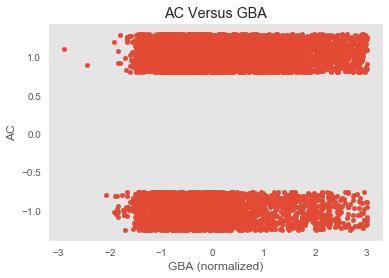

In [32]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = df[['AC','GBA']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('GBA (normalized)'), plt.ylabel('AC')
plt.grid()
plt.title('AC Versus GBA')
plt.show()


Creating below code we were inspired by https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters = 2 The average silhouette_score is : 0.57 Average accuracy (with kmeans for class/fare)=  72.53 +- 0.49
For n_clusters = 3 The average silhouette_score is : 0.62 Average accuracy (with kmeans for class/fare)=  72.63 +- 0.7
For n_clusters = 4 The average silhouette_score is : 0.62 Average accuracy (with kmeans for class/fare)=  72.7 +- 0.57


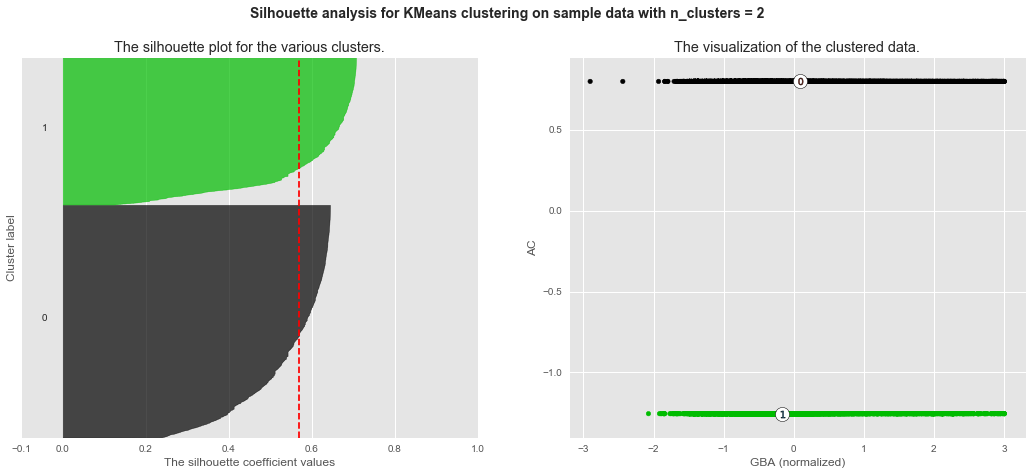

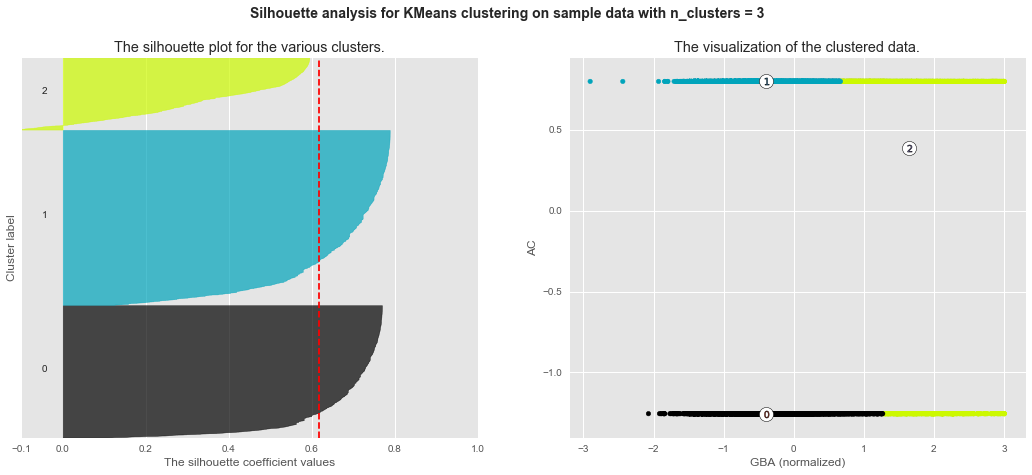

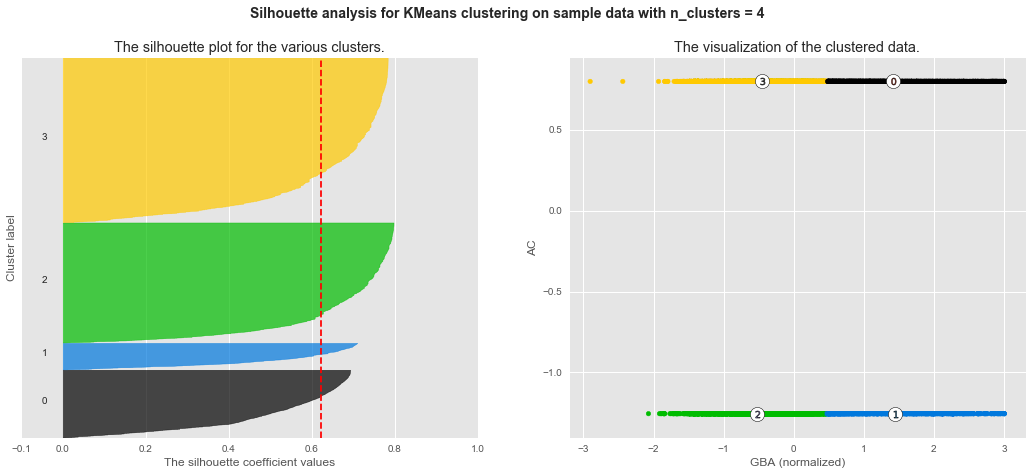

Wall time: 3min 4s


In [33]:
%%time

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

X1 = df[['GBA','AC']]

range_n_clusters = [2,3,4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X1) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X1)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X1, cluster_labels)
    X = np.column_stack((X,pd.get_dummies(cluster_labels)))
    acc = cross_val_score(lr_clf,X,y=y,cv=5)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg,2),
         "Average accuracy (with kmeans for class/fare)= ", round(acc.mean()*100,2), "+-", round(acc.std()*100,2))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X1, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X1['GBA'], X1['AC'], s=20,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("GBA (normalized)")
    ax2.set_ylabel("AC")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The silhouette plot shows that the n_clusters value of 3 is a bad pick for the given data due to the presence of cluster with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 4. After review of silhouette plots using n_clusters value of 2 and 4, we can pick the one that provided higher silhouette score, that is n_clusters=4 with silhouette score=0.62.

Let's now try adding in different discretization of the features.

For n_clusters = 7 The average silhouette_score is : 0.46 Average accuracy (with kmeans for LATITUDE/LONGITUDE)=  76.65 +- 0.53
For n_clusters = 8 The average silhouette_score is : 0.47 Average accuracy (with kmeans for LATITUDE/LONGITUDE)=  79.77 +- 0.3
For n_clusters = 9 The average silhouette_score is : 0.47 Average accuracy (with kmeans for LATITUDE/LONGITUDE)=  80.11 +- 0.31
For n_clusters = 10 The average silhouette_score is : 0.46 Average accuracy (with kmeans for LATITUDE/LONGITUDE)=  80.78 +- 0.25
For n_clusters = 12 The average silhouette_score is : 0.46 Average accuracy (with kmeans for LATITUDE/LONGITUDE)=  81.84 +- 0.33
For n_clusters = 14 The average silhouette_score is : 0.43 Average accuracy (with kmeans for LATITUDE/LONGITUDE)=  82.81 +- 0.25


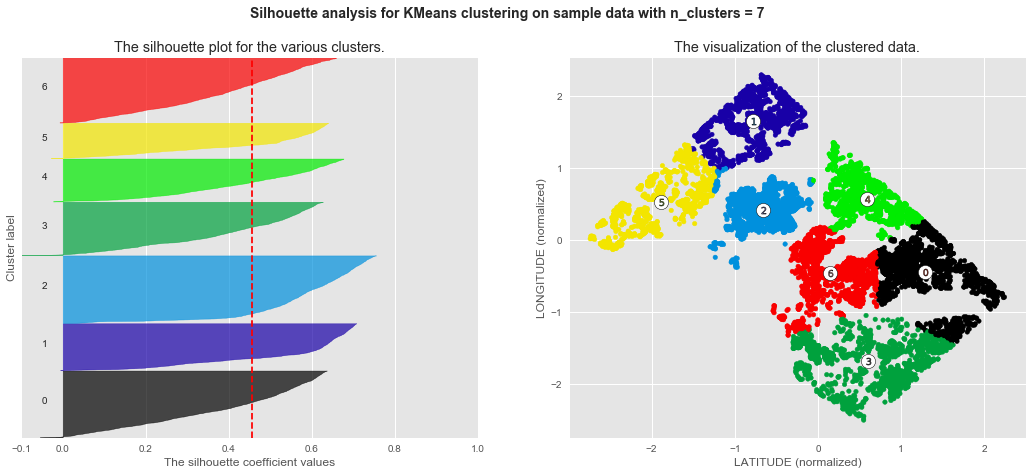

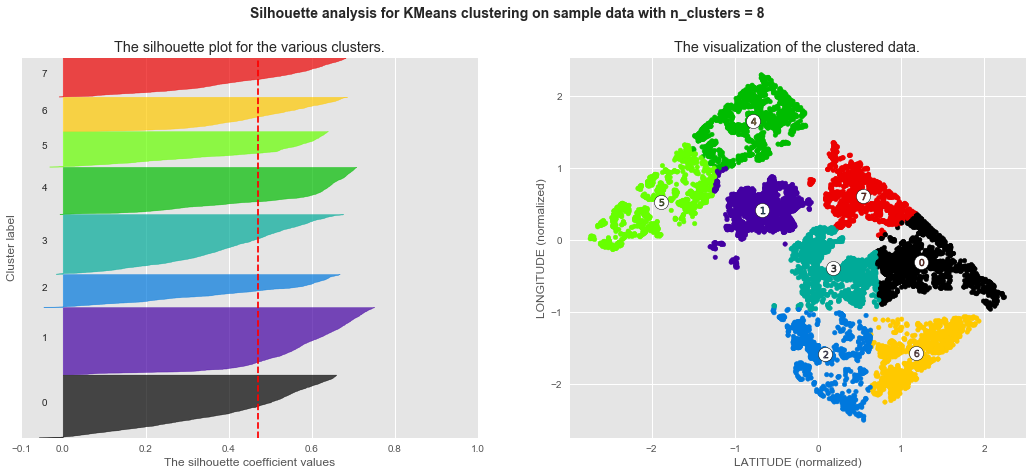

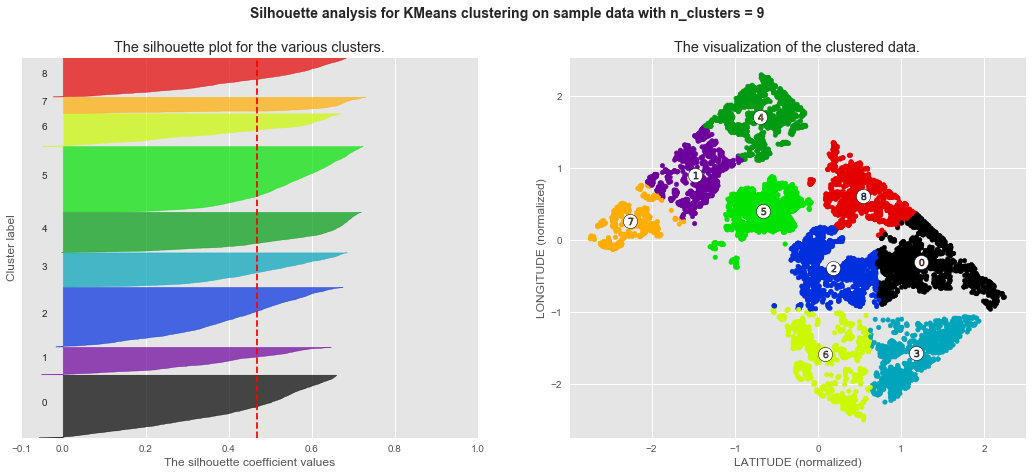

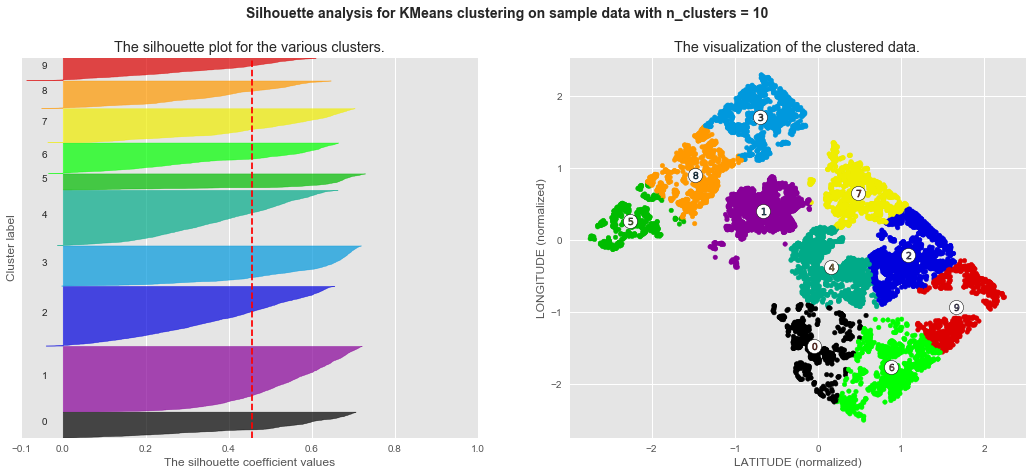

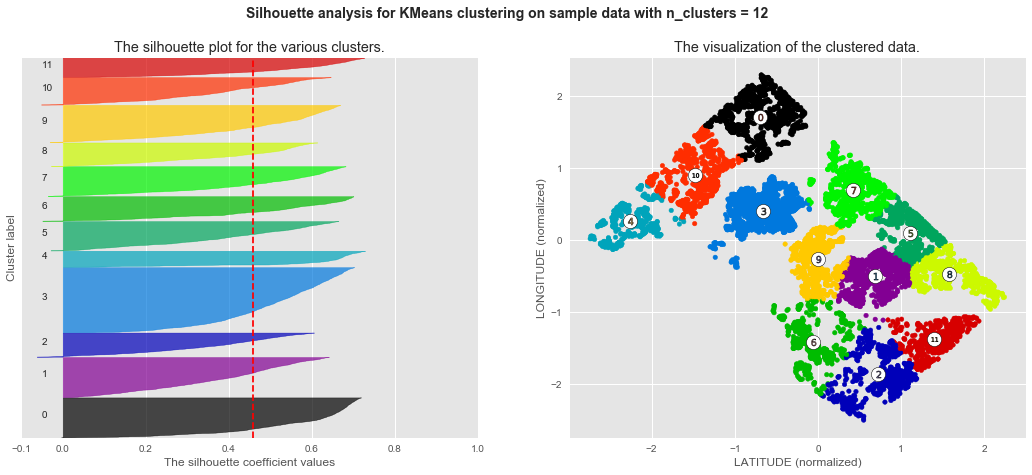

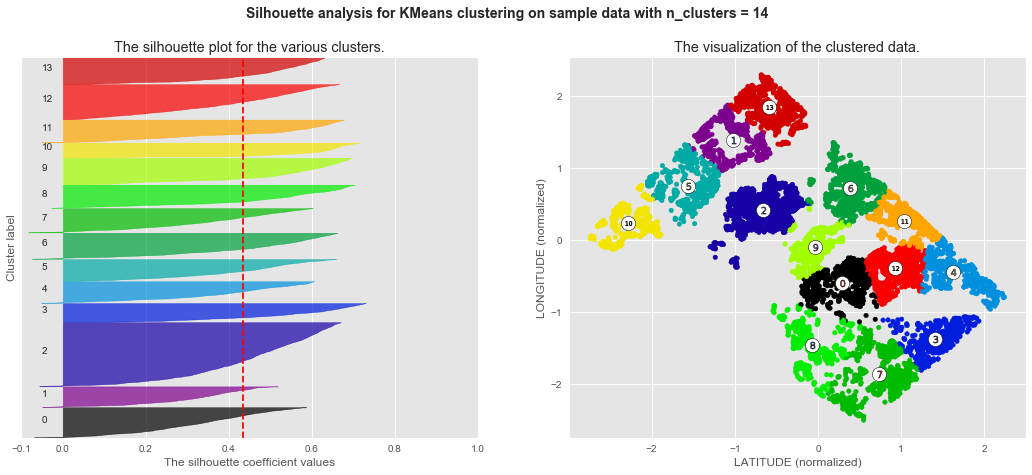

Wall time: 7min 28s


In [34]:
%%time

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

X1 = df[['LATITUDE','LONGITUDE']]

range_n_clusters = [7,8,9,10,12,14]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X1) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X1)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X1, cluster_labels)
    X = np.column_stack((X,pd.get_dummies(cluster_labels)))
    acc = cross_val_score(lr_clf,X,y=y,cv=5)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg,2),
         "Average accuracy (with kmeans for LATITUDE/LONGITUDE)= ", round(acc.mean()*100,2), "+-", round(acc.std()*100,2))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X1, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X1['LATITUDE'], X1['LONGITUDE'], s=20,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("LATITUDE (normalized)")
    ax2.set_ylabel("LONGITUDE (normalized)")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The highest silhouette score for clustering of attributes LATITUDE and LONGITUDE is 0.47 with n_clusters = 8. And this result agrees with total of 8 wards that we have in the data set.

Now lets do DBSCAN clustering for attributes: AYB (the earliest time when the main portion of builfing was built), SALE_NUM.

In [35]:
%%time

from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

X1 = df[['LATITUDE','LONGITUDE']]

for eps in [0.125, 0.13, 0.14]:
    for mpts in [40, 50, 60]:
    
        cls_fam = DBSCAN(eps=eps, min_samples=mpts)
        cluster_labels = cls_fam.fit_predict(X1)

        silhouette_avg = silhouette_score(X1, cluster_labels)
        X = np.column_stack((X,pd.get_dummies(cluster_labels)))
        acc = cross_val_score(lr_clf,X,y=y,cv=5)
        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        print("For eps =", eps,
              "For mpts =", mpts,
              "Estimated number of clusters: %d" % n_clusters_,
              "The average silhouette_score is :", round(silhouette_avg,2),
              "Average accuracy (with DBSCAN for LATITUDE/LONGITUDE)= ", round(acc.mean()*100,2), "+-", round(acc.std()*100,2))  

  

For eps = 0.125 For mpts = 40 Estimated number of clusters: 12 The average silhouette_score is : 0.28 Average accuracy (with DBSCAN for LATITUDE/LONGITUDE)=  84.45 +- 0.37
For eps = 0.125 For mpts = 50 Estimated number of clusters: 15 The average silhouette_score is : 0.2 Average accuracy (with DBSCAN for LATITUDE/LONGITUDE)=  85.31 +- 0.3
For eps = 0.125 For mpts = 60 Estimated number of clusters: 15 The average silhouette_score is : 0.16 Average accuracy (with DBSCAN for LATITUDE/LONGITUDE)=  86.02 +- 0.36
For eps = 0.13 For mpts = 40 Estimated number of clusters: 11 The average silhouette_score is : 0.3 Average accuracy (with DBSCAN for LATITUDE/LONGITUDE)=  86.17 +- 0.37
For eps = 0.13 For mpts = 50 Estimated number of clusters: 12 The average silhouette_score is : 0.29 Average accuracy (with DBSCAN for LATITUDE/LONGITUDE)=  86.21 +- 0.39
For eps = 0.13 For mpts = 60 Estimated number of clusters: 15 The average silhouette_score is : 0.14 Average accuracy (with DBSCAN for LATITUDE/L

Lets visualize DBSCAN clustering that has the highest silhouette_score.

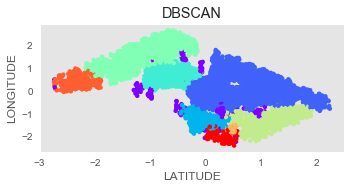

In [37]:
data = X1

cls = DBSCAN(eps=0.14, min_samples=40)
cls.fit(data)
dbs_labels = cls.labels_ 

fig = plt.figure(figsize=(12,8))

for i,l in enumerate([dbs_labels]):
    
    plt.subplot(3,2,2*i+1)
    plt.scatter(data['LATITUDE'], data['LONGITUDE']+np.random.random(data['LONGITUDE'].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('LATITUDE'), plt.ylabel('LONGITUDE')
    plt.grid()
    plt.title("DBSCAN")

    

### Lets do KMeans for PCA

In [62]:
from sklearn.decomposition import PCA
pca=PCA(n_components=3)
X=df[['BATHRM','HF_BATHRM','ROOMS','BEDRM','GBA','LANDAREA']]
X_pca = pca.fit(X).transform(X)
print ('pca:', pca.components_)

pca: [[ 0.4533972   0.11772743  0.47232188  0.46597073  0.49674512  0.30593928]
 [-0.16368301  0.03446116 -0.18976805 -0.20184626 -0.07012967  0.9435827 ]
 [ 0.1323863  -0.97950124  0.09810354  0.04099163 -0.07090871  0.08196659]]


In [63]:
pca.explained_variance_ratio_

array([0.43832986, 0.24204857, 0.14858583])

These PCA explain 86% of the variance of the 'BATHRM','HF_BATHRM','ROOMS','BEDRM','GBA','LANDAREA'.

In [64]:
principalDf = pd.DataFrame(data = X_pca
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf.head()

,principal component 1,principal component 2,principal component 3
0,1.293291,1.483603,-0.662041
1,-2.151143,0.059749,-0.957111
2,-1.092314,-0.315264,-0.912057
3,0.963808,2.701716,-0.462472
4,-2.005335,0.153936,-0.963311


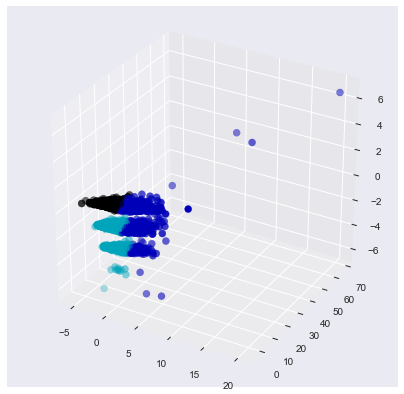

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

X = principalDf

k_means = KMeans(n_clusters=3, random_state=50)
# compute k-means clustering

k_means.fit(X)
# compute cluster centers and predict cluster index for each sample

k_means_predicted = k_means.predict(X)


centroids = k_means.cluster_centers_
#target_names = iris.target_names
colors = cm.nipy_spectral(k_means_predicted.astype(float) / n_clusters)

plt.figure('K-Means on Iris Dataset', figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter(X['principal component 1'],X['principal component 2'],X['principal component 3'],c=colors, s=50)
#ax.legend()

### SpectralClustering

In [117]:
from sklearn.cluster import SpectralClustering
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
%matplotlib inline

X = principalDf

range_n_clusters = [3,4,5,6,7,8,9]

for n_clusters in range_n_clusters:
    
        spc = SpectralClustering(n_clusters=n_clusters, affinity = 'nearest_neighbors')
        labels = spc.fit_predict(X)

        silhouette_avg = silhouette_score(X, labels)
        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        print("Estimated number of clusters: %d" % n_clusters_,
              "The average silhouette_score is :", round(silhouette_avg,2))
              

C:\Users\otany\Anaconda3\lib\site-packages\scipy\sparse\csgraph\_laplacian.py:72: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.



Estimated number of clusters: 3 The average silhouette_score is : 0.25
Estimated number of clusters: 4 The average silhouette_score is : 0.24
Estimated number of clusters: 5 The average silhouette_score is : 0.26
Estimated number of clusters: 6 The average silhouette_score is : 0.28
Estimated number of clusters: 7 The average silhouette_score is : 0.27
Estimated number of clusters: 8 The average silhouette_score is : 0.27
Estimated number of clusters: 9 The average silhouette_score is : 0.26


C:\Users\otany\Anaconda3\lib\site-packages\scipy\sparse\csgraph\_laplacian.py:72: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.



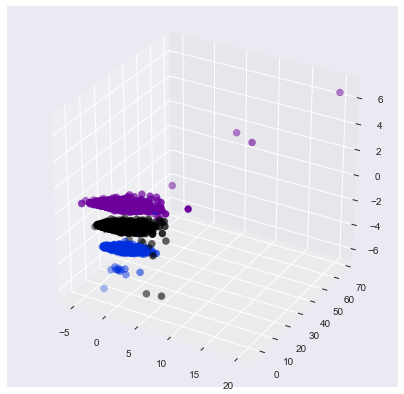

In [118]:
spc = SpectralClustering(n_clusters=3, affinity = 'nearest_neighbors')
labels = spc.fit_predict(X)

colors = cm.nipy_spectral(labels.astype(float) / n_clusters)

plt.figure('SpectralClustering', figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter(X['principal component 1'],X['principal component 2'],X['principal component 3'],c=colors, s=50)


## Modeling and Evaluation 2
<font color=blue>Evaluate and Compare</font> 

## Modeling and Evaluation 3
<font color=blue>Visualize Results</font>

## Modeling and Evaluation 4  
<font color=blue>Summarize the Ramifications</font>  
Blah blah.   

## Deployment
<font color=blue>Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?</font>  
Blah derper blah blah blah.  

## Exceptional Work  
<font color=blue>You have free reign to provide additional analyses or combine analyses.</font>  

Blah blah. Blah blah blah BLAH!  

### Appendix 

In [ ]:
df.info()

- OBJECTID: Auto-generated internal unique ID
- SSL: Square, suffix, lot ID
- BATHRM: Number of full bathrooms
- HF_BATHRM: Number of half bathrooms (no shower or tub)
- HEAT: Heating code
    - 0: No Data
    - 1: Forced Air
    - 2: Air-Oil
    - 3: Wall Furnace
    - 4: Electric Rad
    - 5: Elec Base Brd
    - 6: Water Base Brd
    - 7: Warm Cool
    - 8: Ht Pump
    - 9: Evp Cool
    - 10: Air Exchng
    - 11: Gravity Furnac
    - 12: Ind Unit
    - 13: Hot Water Rad
- AC: Air conditioning (Y/N)
- NUM_UNITS: Number of units
- ROOMS: Number of rooms
- BEDRM: Number of bedrooms
- AYB: The earliest time the main portion of the building was built. It is not affected by subsequent construction.
- STORIES: Stories
- SALE_NUM: Sale number
- GBA: Gross building area in square feet
- STYLE: Style code
    - 0: Default
    - 1: 1 Story
    - 2: 1.5 Story Unfin
    - 3: 1.5 Story Fin
    - 4: 2 Story
    - 5: 2.5 Story Unfin
    - 6: 2.5 Story Fin
    - 7: 3 Story
    - 8: 3.5 Story
    - 9: 3.5 Story Fin
    - 10: 4 Story
    - 11: 4.5 Story Unfin
    - 12: 4.5 Story Fin
    - 13: Bi-Level
    - 14: Split Level
    - 15: Split Foyer
    - 94: Outbuildings
    - 99: Vacant
- STRUCT: Structure code
    - 0: Default
    - 1: Single
    - 2: Multi
    - 4: Town End
    - 5: Town Inside
    - 6: Row End
    - 7: Row Inside
    - 8: Semi-Detached
    - 13: Vacant Land
- EXTWALL: Exterior wall code
    - 0: Default              
    - 1: Plywood
    - 2: Hardboard
    - 3: Metal Siding
    - 4: Vinyl Siding
    - 5: Stucco
    - 6: Wood Siding
    - 7: Shingle
    - 8: SPlaster
    - 9: Rustic Log
    - 10: Brick Veneer
    - 11: Stone Veneer
    - 12: Concrete Block
    - 13: Stucco Block
    - 14: Common Brick
    - 15: Face Brick
    - 16: Adobe
    - 17: Stone
    - 18: Concrete
    - 19: Aluminum
    - 20: Brick/Stone
    - 21: Brick/Stucco
    - 22: Brick/Siding
    - 23: Stone/Stucco
    - 24: Stone/Siding
- ROOF: Roof type code
    - 0: Typical
    - 1: Comp Shingle
    - 2: Built Up
    - 3: Shingle
    - 4: Shake
    - 5: Metal- Pre
    - 6: Metal- Sms
    - 7: Metal- Cpr
    - 8: Composition Ro
    - 9: Concrete Tile
    - 10: Clay Tile
    - 11: Slate
    - 12: Concrete
    - 13: Neopren
    - 14: Water Proof
    - 15: Wood- FS
- INTWALL: Interior wall code
    - 0: Default
    - 1: Resiliant
    - 2: Carpet
    - 3: Wood Floor
    - 4: Ceramic Tile
    - 5: Terrazo
    - 6: Hardwood
    - 7: Parquet
    - 8: Vinyl Comp
    - 9: Vinyl Sheet
    - 10: Lt Concrete
    - 11: Hardwood/Carp
- KITCHENS: Number of kitchens
- FIREPLACES: Number of fireplaces
- LANDAREA: Land area of property in square feet
- LATITUDE: Lattitude of address
- LONGITUDE: Longitude of Address
- ASSESSMENT_NBHD: DC Neighborhood
- WARD: DC Wards

In [ ]:
df.groupby(['WARD']).OBJECTID.count()

In [ ]:
df.groupby(['ASSESSMENT_NBHD']).OBJECTID.count()